**Importing Data from .mat files**

In [1]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms


mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


**Constructing the input tensor with dimensions n_samples x n_paths x n_bs x n_features**

In [2]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


In [3]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep neural network approach**

In [4]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ## assuming we know the minimum coordinates
#of UE 
true_cord_tensor = true_cord_tensor*1



model = models.Sequential()
model.add(layers.Dense(256, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam(learning_rate=5e-5)

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
_________________________________________________________________
None


In [5]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

In [6]:
model.fit(scaled_df, y_train, epochs=200, batch_size=64, verbose = 2)

Epoch 1/200
1172/1172 - 1s - loss: 15355.3711
Epoch 2/200
1172/1172 - 1s - loss: 1173.4606
Epoch 3/200
1172/1172 - 1s - loss: 517.3835
Epoch 4/200
1172/1172 - 1s - loss: 323.3412
Epoch 5/200
1172/1172 - 2s - loss: 231.2917
Epoch 6/200
1172/1172 - 1s - loss: 177.6306
Epoch 7/200
1172/1172 - 1s - loss: 141.3274
Epoch 8/200
1172/1172 - 1s - loss: 115.2633
Epoch 9/200
1172/1172 - 1s - loss: 95.8286
Epoch 10/200
1172/1172 - 2s - loss: 81.0213
Epoch 11/200
1172/1172 - 1s - loss: 69.3183
Epoch 12/200
1172/1172 - 2s - loss: 60.0137
Epoch 13/200
1172/1172 - 2s - loss: 52.4678
Epoch 14/200
1172/1172 - 2s - loss: 46.1751
Epoch 15/200
1172/1172 - 1s - loss: 40.9275
Epoch 16/200
1172/1172 - 2s - loss: 36.4336
Epoch 17/200
1172/1172 - 1s - loss: 32.5500
Epoch 18/200
1172/1172 - 1s - loss: 29.1970
Epoch 19/200
1172/1172 - 1s - loss: 26.2855
Epoch 20/200
1172/1172 - 2s - loss: 23.7985
Epoch 21/200
1172/1172 - 2s - loss: 21.6141
Epoch 22/200
1172/1172 - 2s - loss: 19.7220
Epoch 23/200
1172/1172 - 2s - 

Epoch 189/200
1172/1172 - 2s - loss: 0.0995
Epoch 190/200
1172/1172 - 2s - loss: 0.0988
Epoch 191/200
1172/1172 - 3s - loss: 0.0897
Epoch 192/200
1172/1172 - 3s - loss: 0.1118
Epoch 193/200
1172/1172 - 3s - loss: 0.0922
Epoch 194/200
1172/1172 - 3s - loss: 0.0768
Epoch 195/200
1172/1172 - 2s - loss: 0.0959
Epoch 196/200
1172/1172 - 2s - loss: 0.1135
Epoch 197/200
1172/1172 - 2s - loss: 0.0916
Epoch 198/200
1172/1172 - 2s - loss: 0.1088
Epoch 199/200
1172/1172 - 2s - loss: 0.0844
Epoch 200/200
1172/1172 - 2s - loss: 0.0905


In [7]:
pred_vals = model.predict(scaler.transform(input_tensor)) +  np.min(true_cord_tensor)*0

pred_train = model.predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In [8]:
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

In [9]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


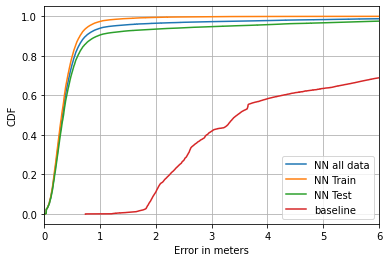

In [10]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

cdf = ECDF(norm_error_train/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])


cdf = ECDF(norm_error_test/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,6])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN all data','NN Train','NN Test','baseline'])

In [11]:
print(np.mean(norm_error))

0.5638259438137073
